In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal,wishart
import sys

# データの確認
## データのロード

In [4]:
df = pd.read_csv("x.csv",header = None) #データをロードしました。
print("データのshape : ",df.shape) #(10000, 3)
df.head()

データのshape :  (10000, 3)


,0,1,2
0,-0.772081,3.30056,-2.14486
1,-1.543720,1.91863,-7.25592
2,6.615610,-1.37613,6.91670
3,-5.519160,2.18445,-2.91299
4,4.744200,-1.61953,4.61999


## 可視化
以下を見る限り、4つのクラスに分割するのが理想に見える・・・

<IPython.core.display.Javascript object>


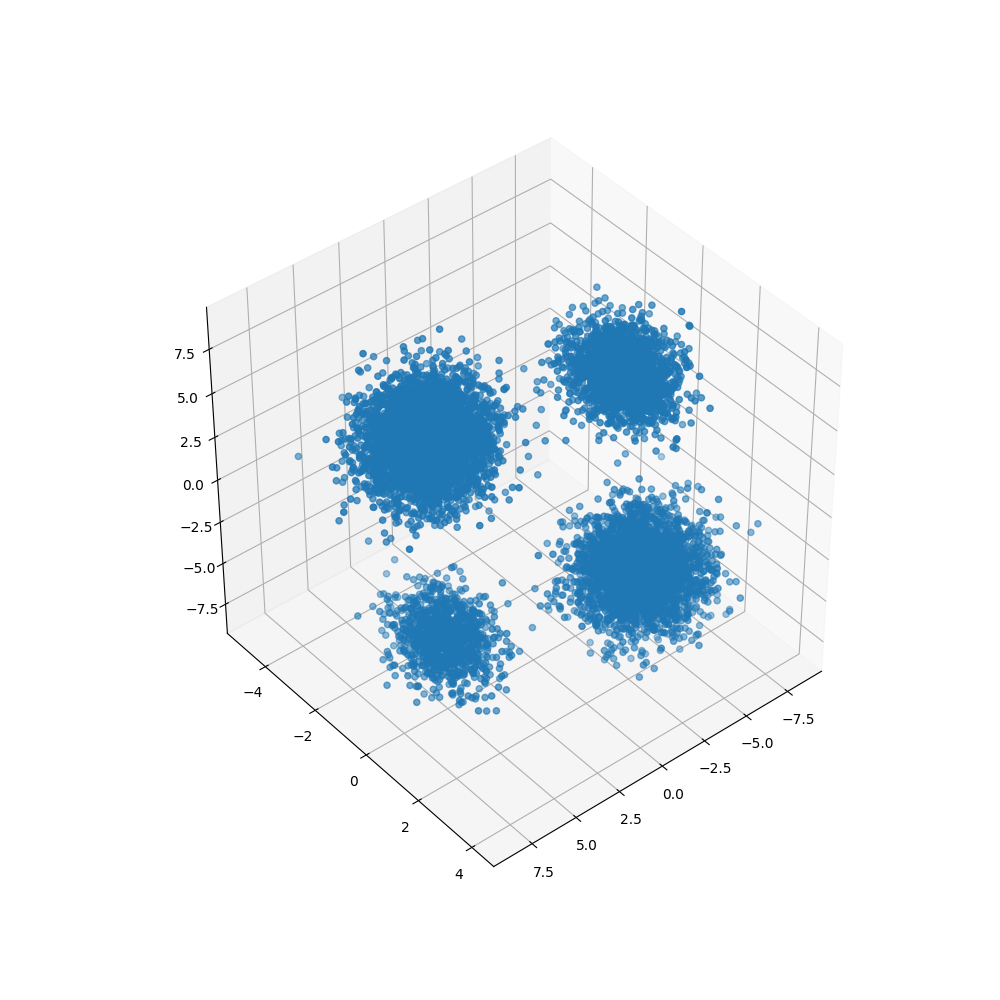

In [5]:
#以下でプロットしています。
rcParams['figure.figsize'] = 10,10
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")
x = df.values
ax.scatter3D(x.T[0],x.T[1],x.T[2])
plt.show()

# 実装

## EMアルゴリズム
今回はGMMを用いてのEMアルゴリズムを実装した。<br>

In [57]:
class EM:
    u"""
    x : 学習用データ
    step : 学習回数
    param : パラメータの二次元辞書 {カテゴリ番号 : {pi: ,m: ,v: }, ... }の形を取っている。
    z : predで推定後の各入力データの各クラスに属する確率"""
    def __init__(self,x):
        self.x = x
    def fit(self,step,param_init):
        u"""
        step : 学習回数
        param_init : パラメータの初期値。実行例のような形式の二次元辞書である必要がある。"""
        if step >= 1:
            self.step = step
        else:
            print("ステップ数は１以上にしてください", file=sys.stderr)
            sys.exit(1)
        self.param = {}
        for c in param_init.keys():
            #二次元辞書だからかまとめてcopyすると、
            #クラス内での操作が外部の引数の辞書の内容に影響を与えるらしいので一つ一つcopy(これ仕様？？)
            self.param[c] = {}
            self.param[c] = param_init[c].copy()
            print("param_init", self.param)
        self.Estep()
    def Estep(self):
        #今回のEステップは混合正規分布の混合比を更新します。
        self.p = [] #現在のパラメータを用いた確率
        for i,para in self.param.items():
            m = para["m"]
            v = para["v"]
            self.p.append(multivariate_normal.pdf(self.x,m,v))
        self.p = np.array(self.p)
        self.g = self.p/np.sum(self.p,axis=0) #ガンマに対応。各データがどの潜在変数に対応するかを示す確率
        self.Mstep()
    def out2(self,x):
        return np.outer(x,x)
    def Mstep(self):
        for c in self.param.keys():
            self.param[c]["pi"] = np.sum(self.g[c])/np.sum(self.g)
            self.param[c]["m"] = np.sum((self.x.T*self.g[c]).T,
                                        axis=0)/np.sum(self.g[c])
            m = self.param[c]["m"]
            self.param[c]["v"] = (np.sum((np.apply_along_axis(self.out2,1,self.x).T*self.g[c]).T,axis=0).T
                                  /np.sum(self.g[c])).T - np.outer(m,m)
        print("==============================================================")
        print(self.param)
        self.step = self.step - 1
        if self.step <= 0:
            pass
        else:
            self.Estep()
    def pred(self,x):
        z = np.array([multivariate_normal.pdf(x,self.param[i]["m"],self.param[i]["v"])
                      for i in self.param.keys()]).T
        z = (z.T/np.sum(z,axis=1)).T
        self.z = z
        return z


def plot_gmm(x,param,color_list):
    rcParams['figure.figsize'] = 10,10
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection="3d")
    z = np.array([multivariate_normal.pdf(x,param[i]["m"],param[i]["v"]) for i in range(len(param))]).T
    z = (z.T/np.sum(z,axis=1)).T
    color = [color_list[i] for i in np.argmax(z,axis=1)]
    ax.scatter3D(x.T[0],x.T[1],x.T[2],color = color)
    plt.show() 


### 実行結果
今回実装したclass EMは引数として、以下を要求する。<br>
・x : 学習に用いるデータ<br>
・step : 学習を行うステップ数<br>
・param_init : パラメータの初期値<br>

In [ ]:
class_num = 4
color_list = {0:"red",1:"blue",2:"green",3:"yellow",4:"pink",5:"orange"}
em = EM(x)
param_i = {}
for i in range(class_num):
    A = np.random.uniform(-10, 10, (3)) #ランダムな行列を平均の初期値として使う
    B = np.random.uniform(-10, 10, (3,3))
    spd = B.dot(B.T) #ランダムな正定値対称行列を分散の初期値として使う
    param_i[i]={"pi" : 1/3,
              "m" : A,
              "v" : spd }

em.fit(30,param_i.copy())
z = em.pred(x)

param_init {0: {'pi': 0.3333333333333333, 'm': array([-4.5329693 ,  3.08291552,  6.85177859]), 'v': array([[  4.52473383, -13.31945269,  -1.04869095],
       [-13.31945269, 206.8447257 , -82.50021738],
       [ -1.04869095, -82.50021738,  44.76497684]])}}
param_init {0: {'pi': 0.3333333333333333, 'm': array([-4.5329693 ,  3.08291552,  6.85177859]), 'v': array([[  4.52473383, -13.31945269,  -1.04869095],
       [-13.31945269, 206.8447257 , -82.50021738],
       [ -1.04869095, -82.50021738,  44.76497684]])}, 1: {'pi': 0.3333333333333333, 'm': array([2.14484853, 1.47642539, 2.60789623]), 'v': array([[ 32.65311683,  49.63400673,  14.46863817],
       [ 49.63400673, 141.60444728,  18.88094601],
       [ 14.46863817,  18.88094601,  39.69726057]])}}
param_init {0: {'pi': 0.3333333333333333, 'm': array([-4.5329693 ,  3.08291552,  6.85177859]), 'v': array([[  4.52473383, -13.31945269,  -1.04869095],
       [-13.31945269, 206.8447257 , -82.50021738],
       [ -1.04869095, -82.50021738,  44.76497

{0: {'pi': 0.20118274181103965, 'm': array([-5.01908476, -0.00702287,  4.97512499]), 'v': array([[ 1.00585206, -0.01641415,  0.01668599],
       [-0.01641415,  0.49970523,  0.00931813],
       [ 0.01668599,  0.00931813,  1.04910473]])}, 1: {'pi': 0.395736734416777, 'm': array([ 2.96036593, -1.99528601,  3.02196513]), 'v': array([[1.97928895, 0.01089611, 0.01636802],
       [0.01089611, 0.48907008, 0.00910516],
       [0.01636802, 0.00910516, 1.9722424 ]])}, 2: {'pi': 0.24103704650799773, 'm': array([-3.32145732,  1.97063504, -3.14992318]), 'v': array([[ 1.52034025,  0.00997249,  0.00456462],
       [ 0.00997249,  0.45764459, -0.071529  ],
       [ 0.00456462, -0.071529  ,  1.98947889]])}, 3: {'pi': 0.1620434772641858, 'm': array([ 2.40192969,  0.75668449, -4.03782265]), 'v': array([[13.36334312, -3.70377448, -4.30053214],
       [-3.70377448,  1.63679426,  1.31160898],
       [-4.30053214,  1.31160898,  2.57301244]])}}
{0: {'pi': 0.2011887547720813, 'm': array([-5.0190266 , -0.00704006

In [ ]:
plot_gmm(x,param_i,color_list) #初期のランダムなパラメータを用いた結果

In [ ]:
plot_gmm(x,em.param,color_list)

## 変分ベイズ

In [520]:
class VB:
    def __init__(self,x):
        u"""
        x : 学習用データ
        step : 学習回数
        param : パラメータの二次元辞書 {カテゴリ番号 : {pi: ,m: ,v: }, ... }の形を取っている。"""
        self.x = x
    def fit(self,step,param_init):
        u"""
        step : 学習回数
        param_init : パラメータの初期値。実行例のような形式の二次元辞書である必要がある。"""
        if step >= 1:
            self.step = step
        else:
            print("ステップ数は１以上にしてください", file=sys.stderr)
            sys.exit(1)
        self.param = {}
        for c in param_init.keys():
            #二次元辞書だからかまとめてcopyすると、
            #クラス内での操作が外部の引数の辞書の内容に影響を与えるらしいので一つ一つcopy(これ仕様？？)
            self.param[c] = {}
            self.param[c] = param_init[c].copy()
        print("param_init", self.param)
        self.Estep()
    def Estep(self):
        #ディリクレ分布に関して更新
        ro = [] #ローに対応
        for c in self.param.keys():
            m,v = self.param[c]["m"], self.param[c]["v"]
            ro.append(multivariate_normal.pdf(self.x,m,v))
        ro = np.array(ro)
        self.g = ro/np.sum(ro,axis=0) #ガンマ
        self.Mstep()
    def out2(self,x):
        return np.outer(x,x)
    def Mstep(self):
        #ガウスウィシャート分布に関して更新
        N_list,x_bar_list,S_list =  [],[],[]
        for c in self.param.keys():
            Nk = np.sum(self.g[c])
            N_list.append(Nk)
            print("N",N_list)
            x_bar = np.sum(x.T*self.g[c],axis=1)/Nk
            x_bar_list.append(x_bar)
            print("x_bar",x_bar)
            #print((np.apply_along_axis(self.out2,1,x-x_bar).T*self.g[c]).T)
            Sk = np.sum((np.apply_along_axis(self.out2,1,x-x_bar).T*self.g[c]).T,axis=0)/Nk
            print("Sk",Sk)
            S_list.append(Sk)
        N_list,x_bar_list,S_list = np.array(N_list),np.array(x_bar_list),np.array(S_list)
        for c in self.param.keys():
            self.param[c]["beta"] = self.beta_init + N[c]
            self.param[c]["m"] = self.beta_init*self.m_init + N[c]
            
        print("g",self.g)
        print(S_list)
        #self.q_gw = 
        self.step = self.step - 1
        if self.step == 0:
            return 1
        else:
            self.Estep()

### 実行結果

In [521]:
vb = VB(x)
param_i = {}
for i in range(3):
    A = np.random.uniform(-5, 6, (3)) #ランダムな行列を平均の初期値として使う
    B = np.random.uniform(-5, 6, (3,3))
    spd = B.dot(B.T) #ランダムな正定値対称行列を分散の初期値として使う
    param_i[i]={"pi" : 1/3,
              "m" : A,
              "v" : spd }
vb.fit(10, param_i)
print(vb.param)

param_init {0: {'pi': 0.3333333333333333, 'm': array([-3.77591037, -3.3771551 , -2.57679088]), 'v': array([[39.8610987 , 20.24619115, 20.19577187],
       [20.24619115, 16.88125857,  4.41593256],
       [20.19577187,  4.41593256, 22.47560311]])}, 1: {'pi': 0.3333333333333333, 'm': array([-1.65840838, -4.97317597,  2.63885626]), 'v': array([[45.23529416, 23.49622289, -8.95908055],
       [23.49622289, 45.30352611, -2.33785641],
       [-8.95908055, -2.33785641, 27.13626238]])}, 2: {'pi': 0.3333333333333333, 'm': array([-0.07173869,  1.14528727,  3.61951842]), 'v': array([[ 18.05102512, -10.01080867,  10.64300757],
       [-10.01080867,  41.69485623,  -0.40822517],
       [ 10.64300757,  -0.40822517,   7.52693812]])}}
N [3702.321026329685]
x_bar [ 0.56374868 -0.19003264 -0.27273983]
[[[  0.88605458  -2.31530684   1.24177557]
  [ -2.31530684   6.05001757  -3.24482434]
  [  1.24177557  -3.24482434   1.74030651]]

 [[  4.14594884  -4.14829767  13.73776418]
  [ -4.14829767   4.15064783 -13.7

Sk [[ 9.87676978 -4.98815576  8.15040602]
 [-4.98815576  3.85975738 -5.68233571]
 [ 8.15040602 -5.68233571 11.33220471]]
N [3702.321026329685, 5307.9160644931435]
x_bar [-1.13102374  0.06801745  0.96633476]
[[[ 6.48651324e-02  5.84158081e-01 -5.62229122e-01]
  [ 5.84158081e-01  5.26077187e+00 -5.06328551e+00]
  [-5.62229122e-01 -5.06328551e+00  4.87321268e+00]]

 [[ 1.13307884e-02 -5.08095208e-02  2.25746239e-01]
  [-5.08095208e-02  2.27840050e-01 -1.01229127e+00]
  [ 2.25746239e-01 -1.01229127e+00  4.49760093e+00]]

 [[ 6.38555399e+00 -1.19041145e+00  4.90488899e+00]
  [-1.19041145e+00  2.21919574e-01 -9.14382059e-01]
  [ 4.90488899e+00 -9.14382059e-01  3.76755658e+00]]

 ...

 [[ 1.02788205e+01 -3.92532964e+00  1.30862751e+01]
  [-3.92532964e+00  1.49902538e+00 -4.99745506e+00]
  [ 1.30862751e+01 -4.99745506e+00  1.66605298e+01]]

 [[ 6.22293679e+00 -3.29823487e+00  1.00150473e+00]
  [-3.29823487e+00  1.74810602e+00 -5.30810120e-01]
  [ 1.00150473e+00 -5.30810120e-01  1.61179803e-01]

Sk [[19.53958272 -3.37446907 -8.52914735]
 [-3.37446907  2.60404537 -2.5666352 ]
 [-8.52914735 -2.5666352  17.13017378]]
N [3702.321026329685, 5307.9160644931435, 989.7629091771713]
x_bar [ 1.43483994 -1.60802067  3.75156061]
[[[ 4.02173979e-15 -8.94505728e-15  1.07452283e-14]
  [-8.94505728e-15  1.98953821e-14 -2.38992794e-14]
  [ 1.07452283e-14 -2.38992794e-14  2.87089514e-14]]

 [[ 8.04831884e-51 -9.52930599e-51  2.97431361e-50]
  [-9.52930599e-51  1.12828125e-50 -3.52162297e-50]
  [ 2.97431361e-50 -3.52162297e-50  1.09917880e-49]]

 [[ 1.83331444e+01  8.20589423e-01  1.12004502e+01]
  [ 8.20589423e-01  3.67294878e-02  5.01330858e-01]
  [ 1.12004502e+01  5.01330858e-01  6.84280246e+00]]

 ...

 [[ 2.30250164e-10 -1.09382632e-10  2.78301802e-10]
  [-1.09382632e-10  5.19633081e-11 -1.32210041e-10]
  [ 2.78301802e-10 -1.32210041e-10  3.36381488e-10]]

 [[ 1.71655722e-06 -5.86732071e-07 -2.14830839e-06]
  [-5.86732071e-07  2.00549401e-07  7.34307842e-07]
  [-2.14830839e-06  7.34307842e-

       [ 3.98960004, -1.76392186,  3.14094514]])]
N [3702.321026329685]
x_bar [ 0.56374868 -0.19003264 -0.27273983]
[[[  0.88605458  -2.31530684   1.24177557]
  [ -2.31530684   6.05001757  -3.24482434]
  [  1.24177557  -3.24482434   1.74030651]]

 [[  4.14594884  -4.14829767  13.73776418]
  [ -4.14829767   4.15064783 -13.74554712]
  [ 13.73776418 -13.74554712  45.52062076]]

 [[  7.71136214  -1.51134103   9.16087979]
  [ -1.51134103   0.296206    -1.79543033]
  [  9.16087979  -1.79543033  10.8828657 ]]

 ...

 [[ 24.96050655  -8.06042568  18.93302098]
  [ -8.06042568   2.60293043  -6.11398684]
  [ 18.93302098  -6.11398684  14.36105805]]

 [[  4.25949369  -3.32670516   3.21022843]
  [ -3.32670516   2.59818843  -2.50721899]
  [  3.21022843  -2.50721899   2.41943463]]

 [[  6.43768358  -4.78295857   6.80313302]
  [ -4.78295857   3.55355967  -5.05447386]
  [  6.80313302  -5.05447386   7.189328  ]]]
Sk [[ 9.87676978 -4.98815576  8.15040602]
 [-4.98815576  3.85975738 -5.68233571]
 [ 8.150406

Sk [[ 9.87676978 -4.98815576  8.15040602]
 [-4.98815576  3.85975738 -5.68233571]
 [ 8.15040602 -5.68233571 11.33220471]]
N [3702.321026329685, 5307.9160644931435]
x_bar [-1.13102374  0.06801745  0.96633476]
[[[ 6.48651324e-02  5.84158081e-01 -5.62229122e-01]
  [ 5.84158081e-01  5.26077187e+00 -5.06328551e+00]
  [-5.62229122e-01 -5.06328551e+00  4.87321268e+00]]

 [[ 1.13307884e-02 -5.08095208e-02  2.25746239e-01]
  [-5.08095208e-02  2.27840050e-01 -1.01229127e+00]
  [ 2.25746239e-01 -1.01229127e+00  4.49760093e+00]]

 [[ 6.38555399e+00 -1.19041145e+00  4.90488899e+00]
  [-1.19041145e+00  2.21919574e-01 -9.14382059e-01]
  [ 4.90488899e+00 -9.14382059e-01  3.76755658e+00]]

 ...

 [[ 1.02788205e+01 -3.92532964e+00  1.30862751e+01]
  [-3.92532964e+00  1.49902538e+00 -4.99745506e+00]
  [ 1.30862751e+01 -4.99745506e+00  1.66605298e+01]]

 [[ 6.22293679e+00 -3.29823487e+00  1.00150473e+00]
  [-3.29823487e+00  1.74810602e+00 -5.30810120e-01]
  [ 1.00150473e+00 -5.30810120e-01  1.61179803e-01]

In [517]:
spd[0:2].T[0:2].T

array([[26.06509936, 13.77683408],
       [13.77683408, 10.18858264]])

1.104067691526856e-23

In [459]:
wishart.pdf(spd[0:2].T[0:2].T,df=3,scale=np.array([[1.0, 0.5], [0.5, 1.0]]))

6.109347204579063e-13

## ギブスサンプリング